## Set up

In [2]:
import pickle
from pathlib import Path

import keras as tfk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

sns.set_theme()

2024-11-22 21:05:17.757278: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 21:05:17.757547: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 21:05:17.760227: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 21:05:17.791203: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 21:05:18.586825: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [3]:
EXPERIMENT = "89-efficientnetv2m"
EXPERIMENT_DIR = Path().absolute().parent / "results" / EXPERIMENT
AUGMENTED_DIR = Path().absolute().parent / "data" / "augmented"

MODEL_PATH = EXPERIMENT_DIR / "model.keras"
HISTORY_PATH = EXPERIMENT_DIR / "history.pkl"
HISTORIES_PATH = EXPERIMENT_DIR / "histories.pkl"
TRAIN_PREDICTIONS_PATH = EXPERIMENT_DIR / "train_predictions.npy"
VAL_PREDICTIONS_PATH = EXPERIMENT_DIR / "val_predictions.npy"

### Load model

In [4]:
model: tfk.Model = tfk.saving.load_model(MODEL_PATH)
model

<Functional name=functional_3, built=True>

In [5]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 96, 96, 3)      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-m (Functional)   │ (None, 1280)           │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,678,862 (204.77 MB)

 Trainable params: 175,304 (684.78 KB)

 Non-trainable params: 53,152,948 (202.76 MB)

 Optimizer params: 350,610 (1.34 MB)

In [6]:
layer_weights: list[np.ndarray] = [
    model.layers[i].weights[0].numpy().flatten()
    for i in (-4, -3, -1)
]

<Axes: >

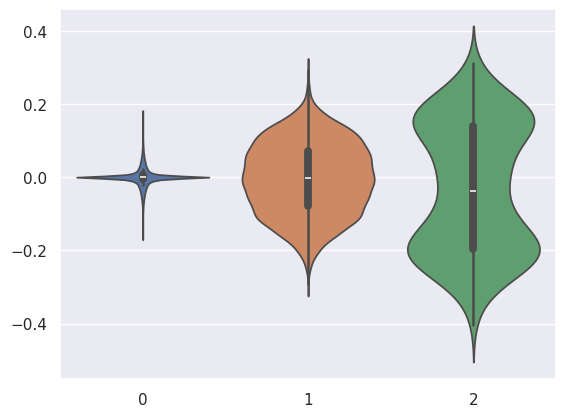

In [9]:
sns.violinplot(layer_weights)

### Load data

In [10]:
BATCH_SIZE = 128
TRAIN_TFDS_DIR = AUGMENTED_DIR / "train"
VAL_TFDS_DIR = AUGMENTED_DIR / "val"

train_dataset = tf.data.Dataset.load(str(TRAIN_TFDS_DIR)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.load(str(VAL_TFDS_DIR)).batch(BATCH_SIZE)

train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.uint8, name=None))>

### Load predictions

In [11]:
y_train_pred = np.load(TRAIN_PREDICTIONS_PATH)
y_val_pred = np.load(VAL_PREDICTIONS_PATH)

print(y_train_pred.shape)
print(y_val_pred.shape)

(5776, 8)
(1016, 8)


In [12]:
X_train = np.concatenate(
    list(train_dataset.map(lambda x, _: x).as_numpy_iterator())
)
y_train = np.concatenate(
    list(train_dataset.map(lambda _, y: y).as_numpy_iterator())
)

X_val = np.concatenate(
    list(val_dataset.map(lambda x, _: x).as_numpy_iterator())
)
y_val = np.concatenate(
    list(val_dataset.map(lambda _, y: y).as_numpy_iterator())
)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

2024-11-22 16:19:14.501511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-22 16:19:15.768478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-22 16:19:15.971362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(5776, 96, 96, 3)
(5776, 8)
(1016, 96, 96, 3)
(1016, 8)


2024-11-22 16:19:16.337630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
def decode(one_hot: np.ndarray) -> np.ndarray:
    return np.argmax(one_hot, axis=1)

In [14]:
label_train = decode(y_train)
label_val = decode(y_val)

label_train_pred = decode(y_train_pred)
label_val_pred = decode(y_val_pred)

In [15]:
outputs = {
    "train": (label_train, label_train_pred),
    "val": (label_val, label_val_pred),
}
outputs

{'train': (array([5, 0, 6, ..., 7, 4, 6]), array([5, 0, 6, ..., 7, 0, 6])),
 'val': (array([5, 1, 4, ..., 0, 4, 7]), array([5, 1, 4, ..., 0, 0, 7]))}

### Load history

In [16]:
if HISTORY_PATH.exists():
    with HISTORY_PATH.open("rb") as f:
        history: tfk.callbacks.History = pickle.load(f)
        history_backbone = None
elif HISTORIES_PATH.exists():
    with HISTORIES_PATH.open("rb") as f:
        histories: list[tfk.callbacks.History] = pickle.load(f)
        history = histories[0]
        history_backbone = histories[1]

In [17]:
history_df = pd.DataFrame(history_backbone)
f1_df = history_df.filter(like="f1_score")
history_df = history_df[history_df.columns.difference(f1_df.columns)]
history_df

accuracy  learning_rate      loss  precision    recall  val_accuracy  \
0   0.900277   1.000000e-06  0.536235   0.924504  0.871364      0.807087   
1   0.892832   1.000000e-06  0.551134   0.917354  0.866690      0.807087   
2   0.900623   1.000000e-06  0.533706   0.925723  0.876039      0.808071   
3   0.903913   1.000000e-06  0.529919   0.931130  0.873096      0.808071   
4   0.902701   1.000000e-06  0.543811   0.924287  0.875000      0.809055   
5   0.905644   1.000000e-06  0.519528   0.930876  0.878982      0.809055   
6   0.898026   1.000000e-06  0.538545   0.919319  0.869979      0.809055   
7   0.896814   1.000000e-06  0.543691   0.924123  0.870845      0.809055   
8   0.898373   1.000000e-06  0.543046   0.924298  0.866690      0.809055   
9   0.904432   1.000000e-06  0.524455   0.926664  0.877251      0.809055   
10  0.905471   1.000000e-06  0.528422   0.928441  0.878289      0.808071   
11  0.901835   1.000000e-07  0.527087   0.924528  0.873788      0.808071   
12  0.906683   1.000000e-07  0.523451   0.927571  0.882445      0.807087   
13  0.908068   1.000000e-07  0.526661   0.931622  0.879848      0.807087   
14  0.899238   1.000000e-07  0.536387   0.925844  0.873269      0.808071   
15  0.903393   1.000000e-07  0.523194   0.928820  0.876558      0.808071   
16  0.905990   1.000000e-07  0.533647   0.927658  0.879155      0.809055   
17  0.903913   1.000000e-07  0.533601   0.928166  0.876904      0.808071   
18  0.904432   1.000000e-07  0.529434   0.930627  0.873269      0.808071   
19  0.910665   1.000000e-07  0.526075   0.932736  0.883483      0.808071   
20  0.904259   1.000000e-07  0.529309   0.925417  0.874307      0.807087   
21  0.899411   1.000000e-08  0.541714   0.924642  0.873096      0.807087   
22  0.904952   1.000000e-08  0.536123   0.928859  0.879328      0.807087   
23  0.908414   1.000000e-08  0.532984   0.929511  0.881233      0.808071   
24  0.900450   1.000000e-08  0.537165   0.925055  0.871884      0.809055   
25  0.901143   1.000000e-08  0.530324   0.924256  0.876731      0.808071   
26  0.902701   1.000000e-08  0.529220   0.926767  0.876385      0.807087   
27  0.904086   1.000000e-08  0.526442   0.927839  0.877078      0.808071   
28  0.903220   1.000000e-08  0.529061   0.927944  0.878463      0.808071   
29  0.900277   1.000000e-08  0.540314   0.924670  0.873442      0.808071   
30  0.902874   1.000000e-08  0.526826   0.927209  0.875519      0.808071   

    val_loss  val_precision  val_recall  
0   0.818200       0.834555    0.784449  
1   0.817676       0.834382    0.783465  
2   0.818352       0.834382    0.783465  
3   0.819673       0.835084    0.782480  
4   0.820633       0.835257    0.783465  
5   0.820993       0.835257    0.783465  
6   0.820487       0.834911    0.781496  
7   0.817699       0.834382    0.783465  
8   0.817155       0.834208    0.782480  
9   0.818040       0.834208    0.782480  
10  0.818135       0.834208    0.782480  
11  0.818918       0.835257    0.783465  
12  0.820458       0.833859    0.780512  
13  0.820627       0.834034    0.781496  
14  0.819132       0.834208    0.782480  
15  0.820384       0.834034    0.781496  
16  0.818028       0.835430    0.784449  
17  0.819169       0.834911    0.781496  
18  0.818674       0.834382    0.783465  
19  0.819567       0.834034    0.781496  
20  0.818713       0.834382    0.783465  
21  0.818732       0.834208    0.782480  
22  0.819650       0.834382    0.783465  
23  0.819734       0.835257    0.783465  
24  0.818544       0.835257    0.783465  
25  0.819325       0.835084    0.782480  
26  0.819603       0.834034    0.781496  
27  0.818913       0.835084    0.782480  
28  0.818176       0.834208    0.782480  
29  0.818759       0.834911    0.781496  
30  0.818190       0.834034    0.781496

## Analyse

### History

In [18]:
molten_history = history_df.reset_index().melt(id_vars="index")
molten_history["val"] = molten_history["variable"].str.contains("val_")
molten_history["variable"] = molten_history["variable"].str.replace("val_", "")
molten_history

index  variable     value    val
0        0  accuracy  0.900277  False
1        1  accuracy  0.892832  False
2        2  accuracy  0.900623  False
3        3  accuracy  0.903913  False
4        4  accuracy  0.902701  False
..     ...       ...       ...    ...
274     26    recall  0.781496   True
275     27    recall  0.782480   True
276     28    recall  0.782480   True
277     29    recall  0.781496   True
278     30    recall  0.781496   True

[279 rows x 4 columns]

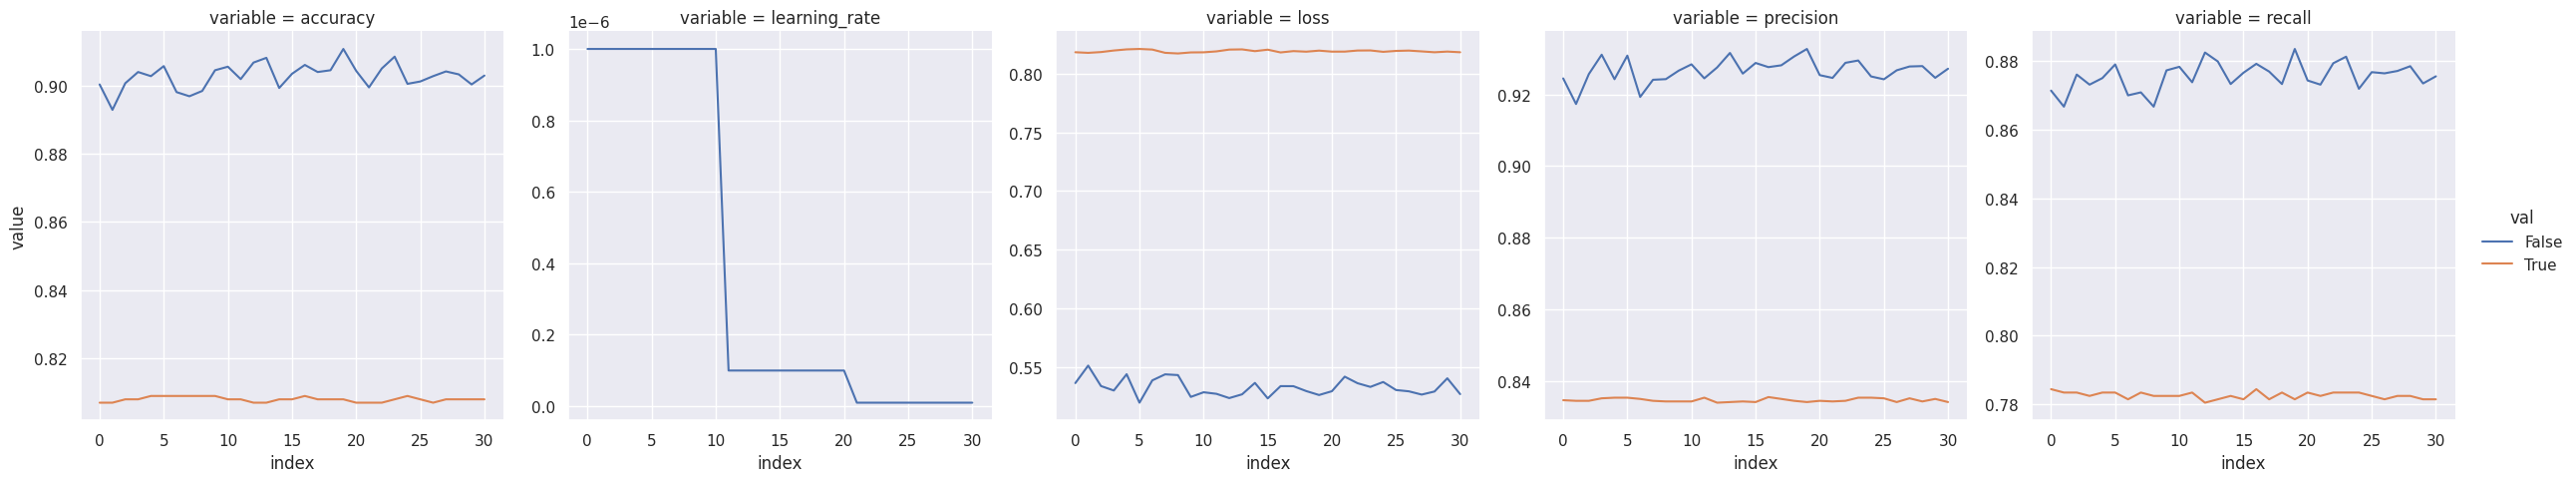

In [19]:
sns.relplot(
    molten_history,
    x="index",
    y="value",
    col="variable",
    hue="val",
    facet_kws={"sharey": False},
    kind="line",
)

### Classification metrics

In [20]:
for set_, (y_true, y_pred) in outputs.items():
    print(set_)
    print(classification_report(y_true, y_pred))
    print()

train
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       722
           1       0.91      0.90      0.90       722
           2       0.87      0.87      0.87       722
           3       0.57      0.82      0.68       722
           4       0.90      0.74      0.81       722
           5       0.85      0.69      0.76       722
           6       0.97      0.70      0.81       722
           7       0.96      0.93      0.95       722

    accuracy                           0.82      5776
   macro avg       0.84      0.82      0.82      5776
weighted avg       0.84      0.82      0.82      5776


val
              precision    recall  f1-score   support

           0       0.71      0.91      0.80       127
           1       0.85      0.86      0.85       127
           2       0.83      0.83      0.83       127
           3       0.58      0.85      0.69       127
           4       0.89      0.74      0.81       127
           5 

### Confusion matrices

In [21]:
def confusion_diag_zero(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    matrix[np.diag_indices_from(matrix)] = 0
    ax = sns.heatmap(matrix, annot=True, fmt="d")
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")
    return ax

Text(0.5, 19.049999999999997, 'Predicted')

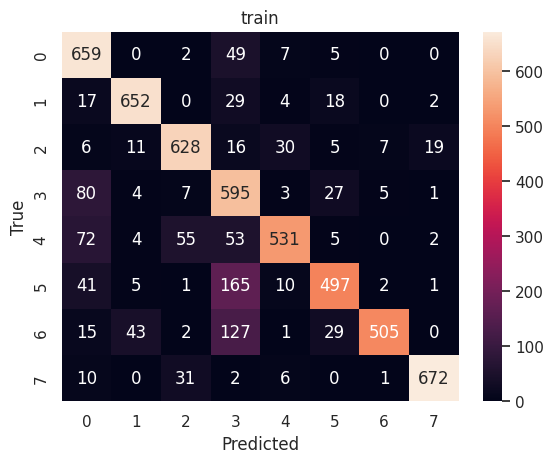

In [22]:
ax = sns.heatmap(confusion_matrix(*outputs["train"]), annot=True, fmt="d")
ax.set_title("train")
ax.set_ylabel("True")
ax.set_xlabel("Predicted")

<Axes: xlabel='Predicted', ylabel='True'>

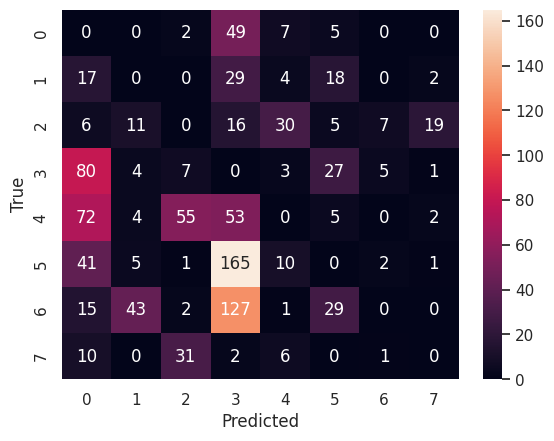

In [23]:
confusion_diag_zero(*outputs["train"])

Text(0.5, 19.049999999999997, 'Predicted')

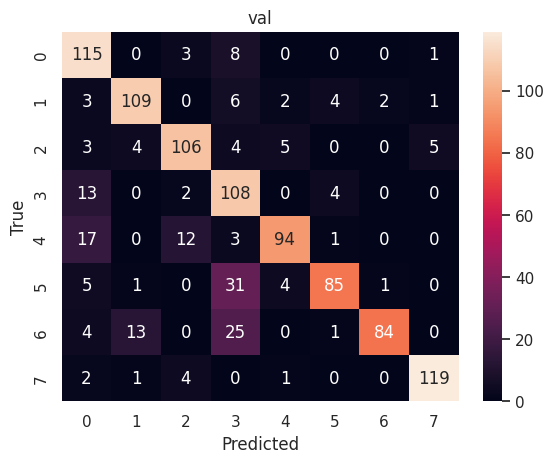

In [24]:
ax = sns.heatmap(confusion_matrix(*outputs["val"]), annot=True, fmt="d")
ax.set_title("val")
ax.set_ylabel("True")
ax.set_xlabel("Predicted")

<Axes: xlabel='Predicted', ylabel='True'>

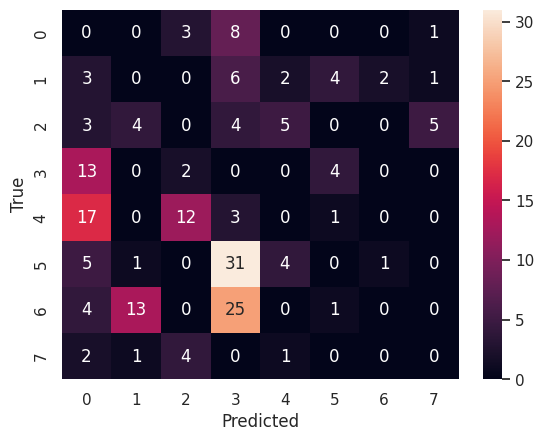

In [25]:
confusion_diag_zero(*outputs["val"])

### Confusion instances

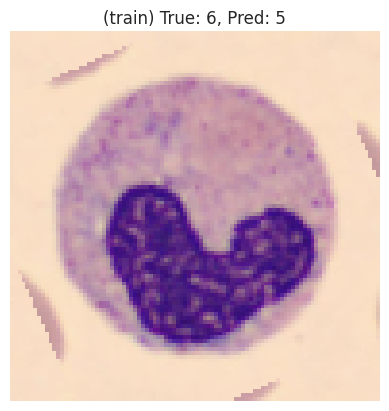

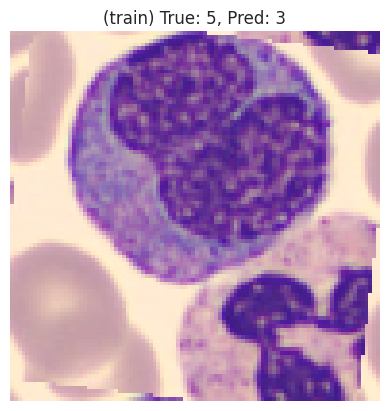

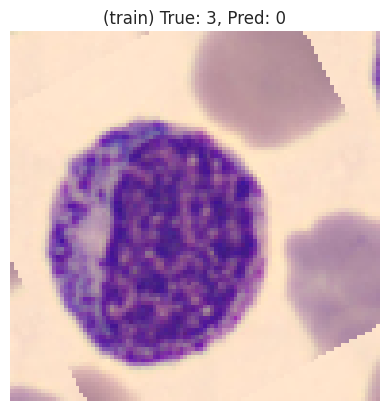

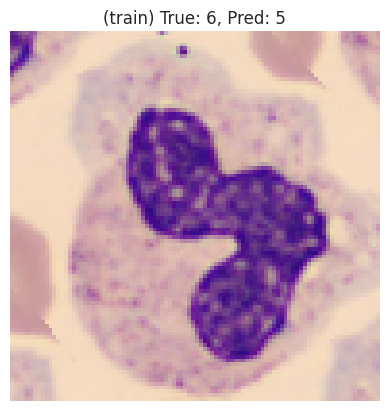

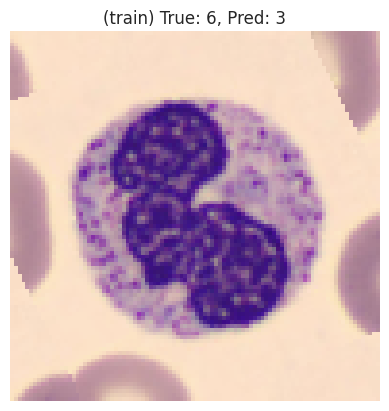

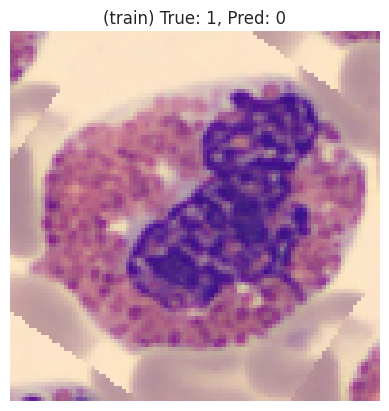

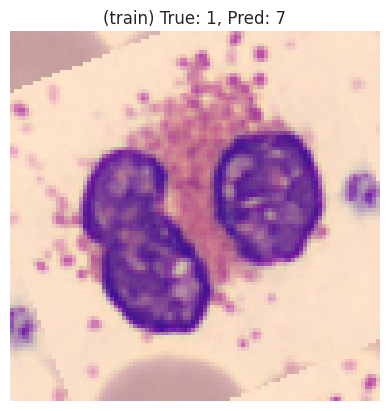

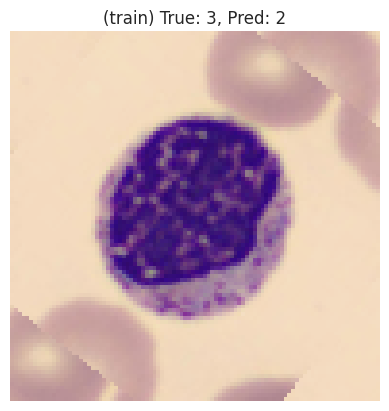

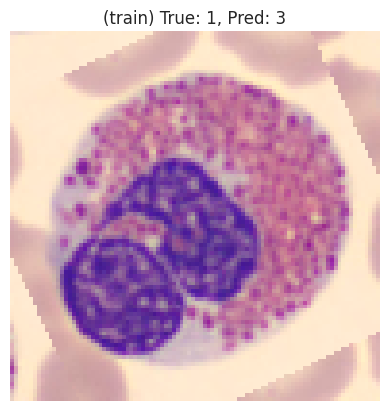

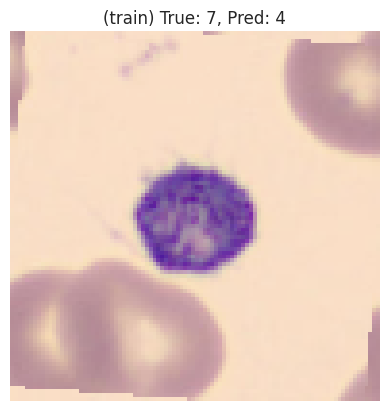

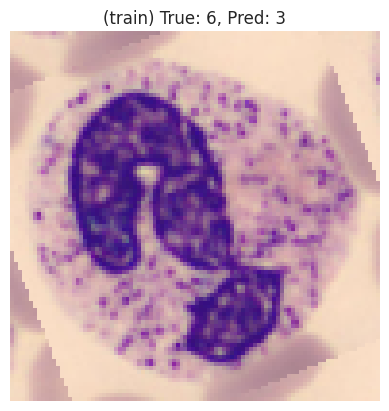

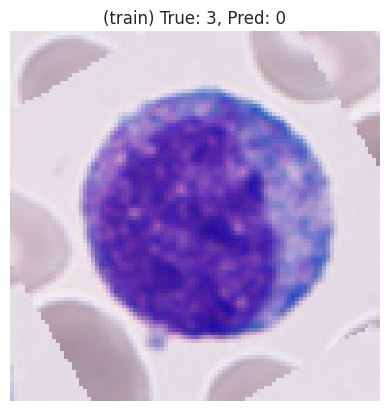

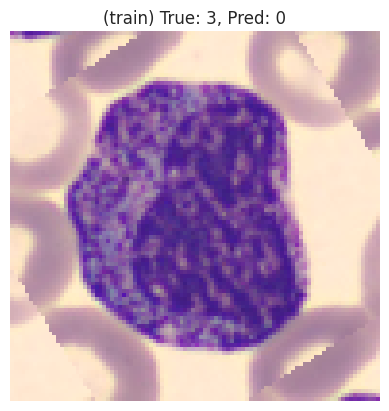

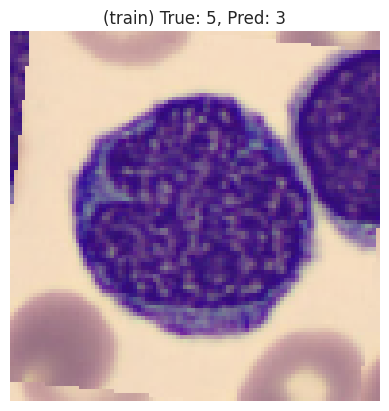

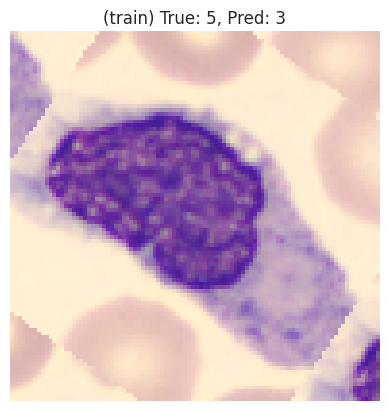

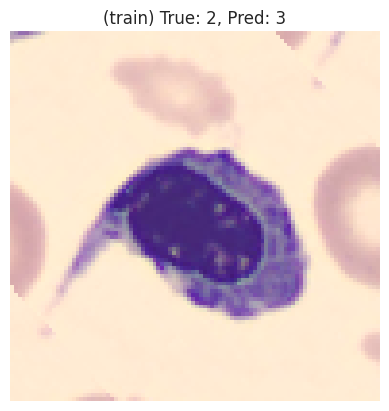

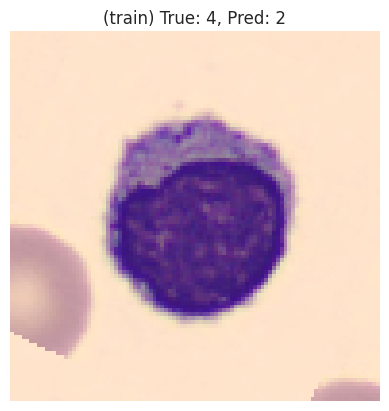

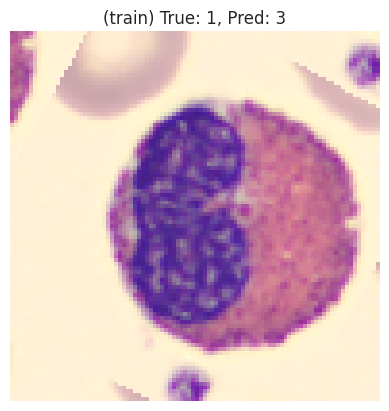

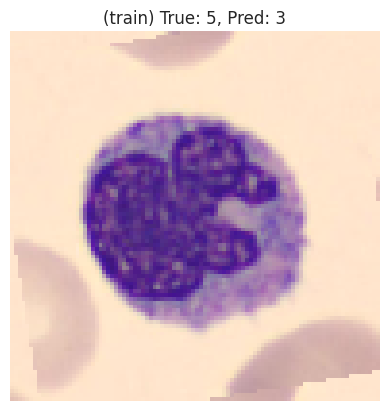

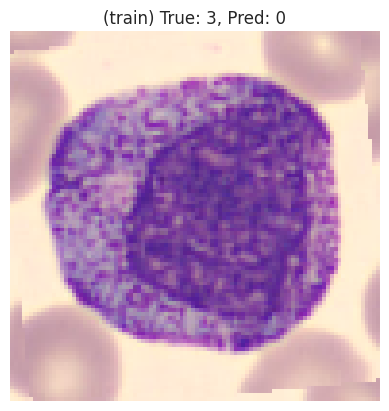

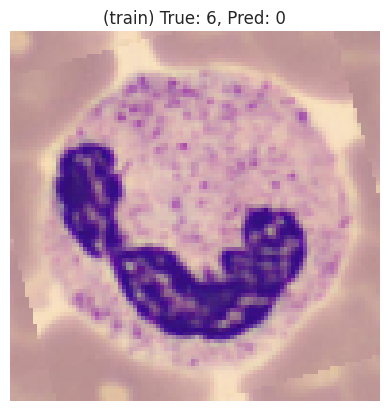

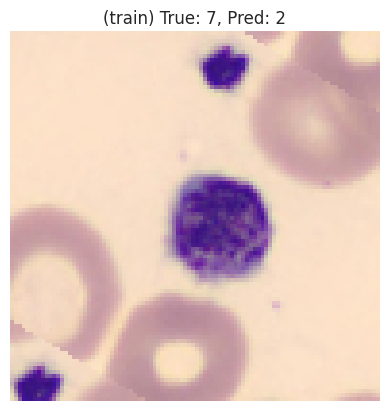

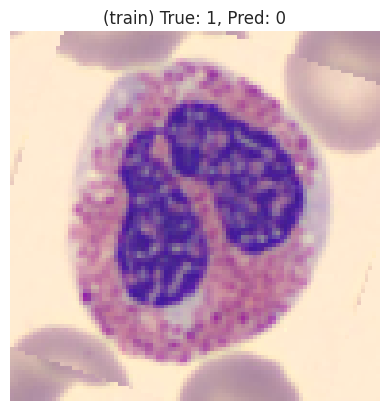

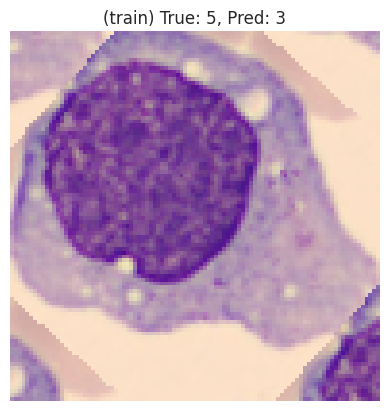

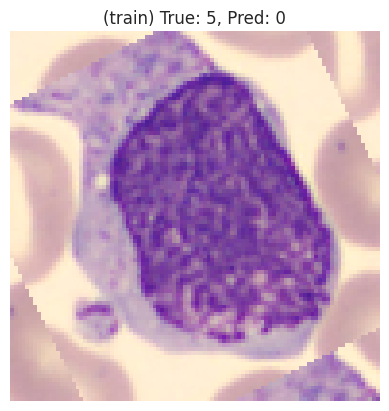

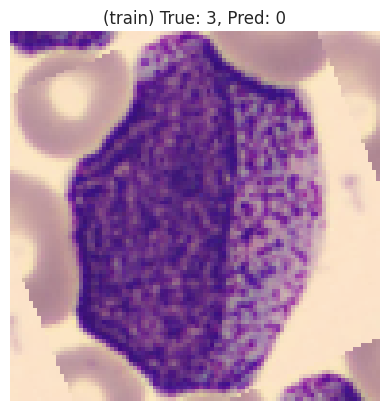

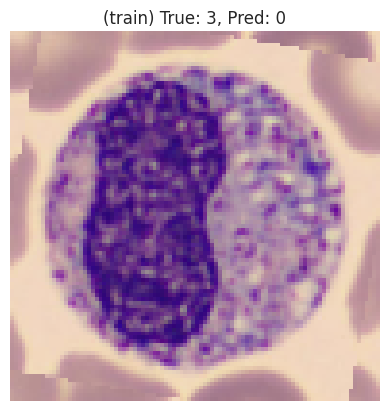

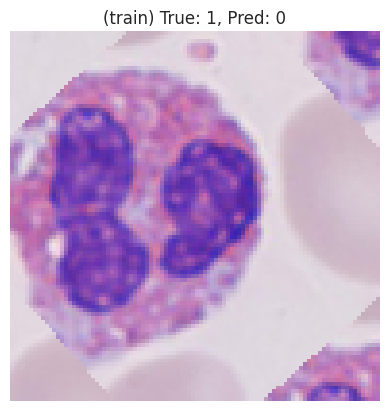

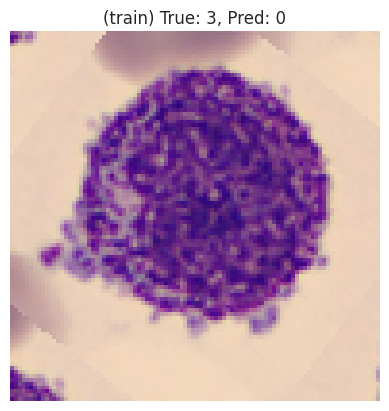

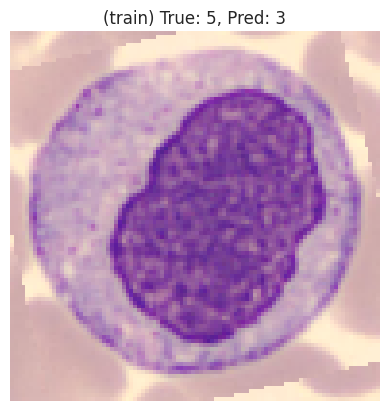

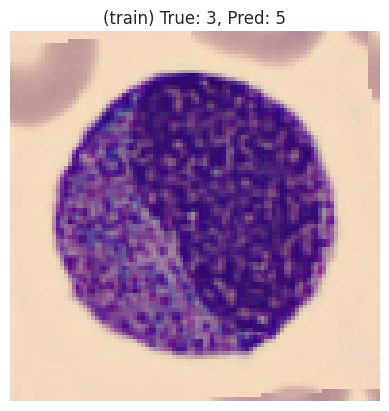

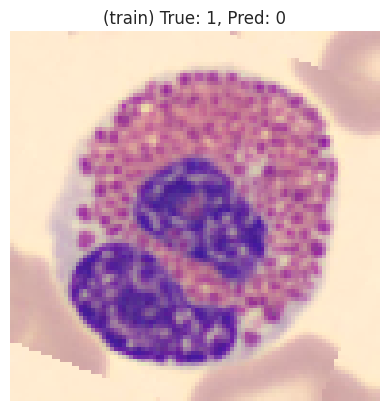

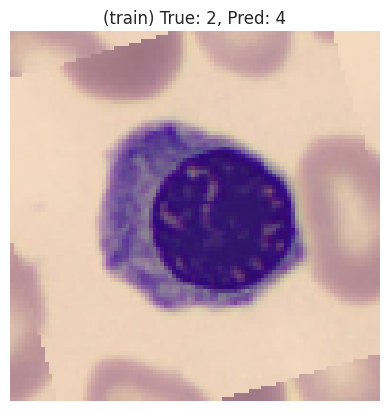

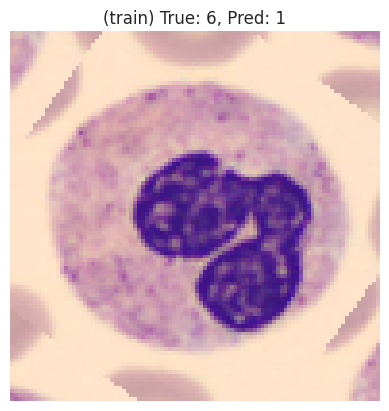

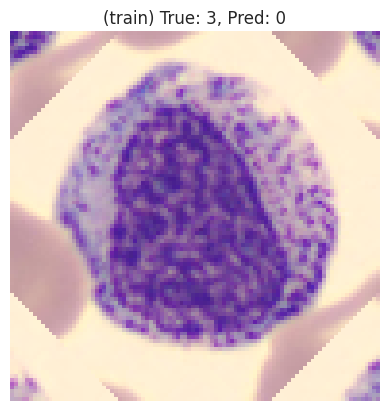

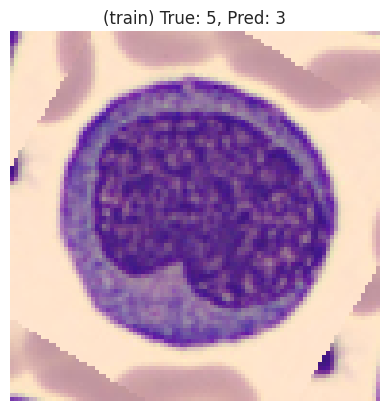

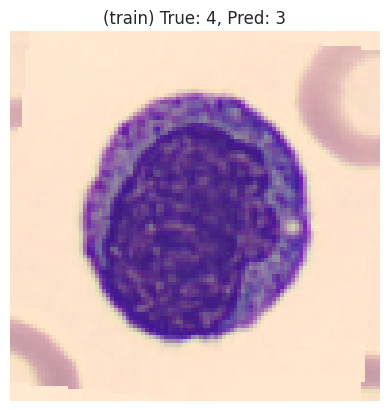

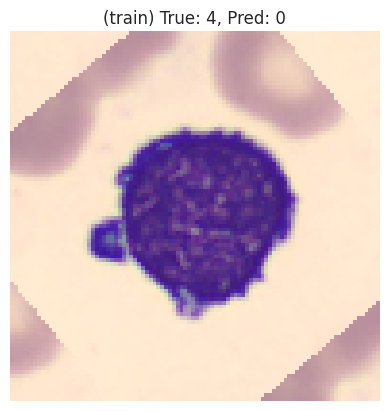

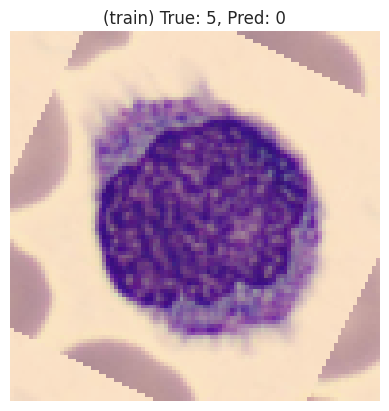

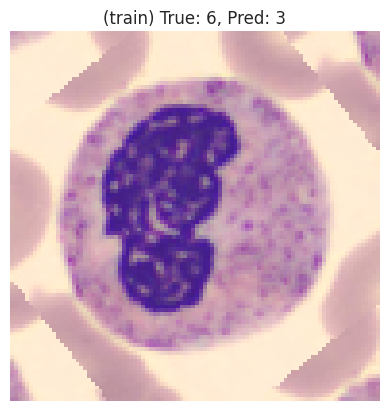

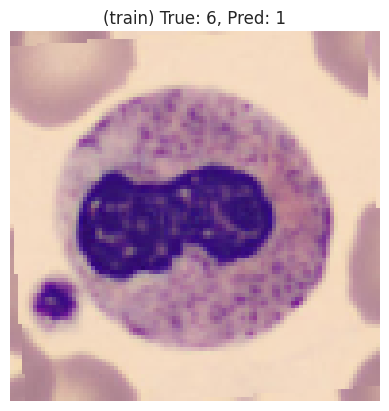

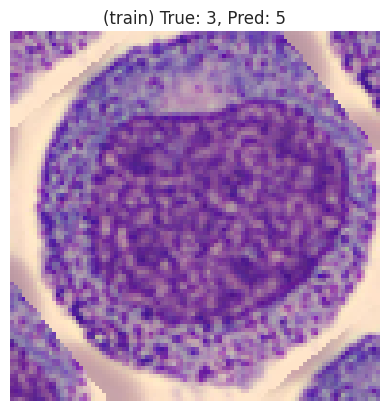

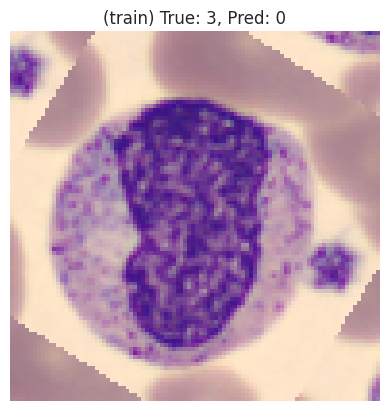

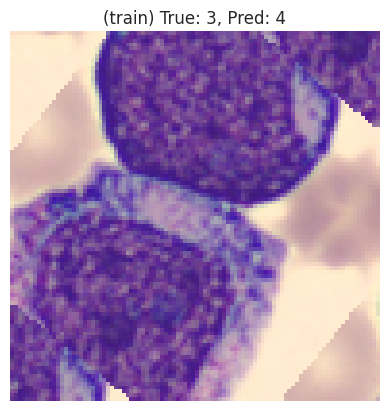

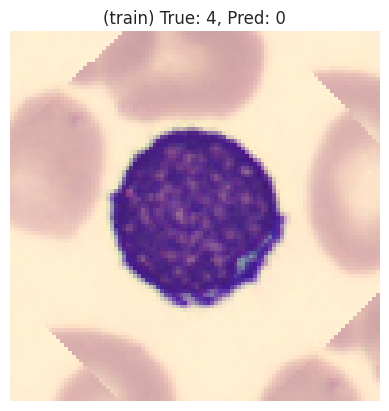

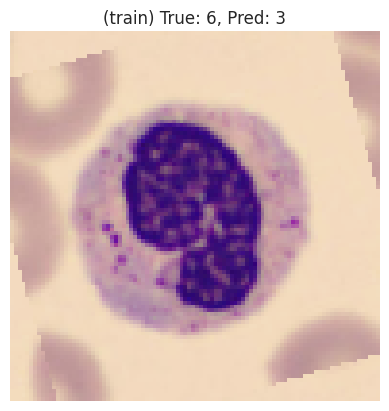

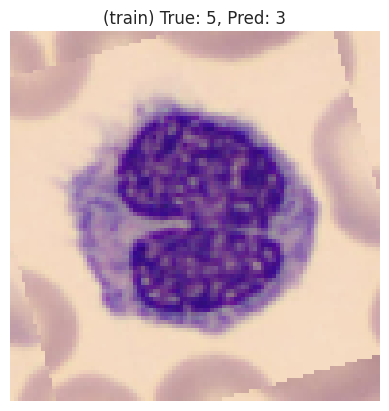

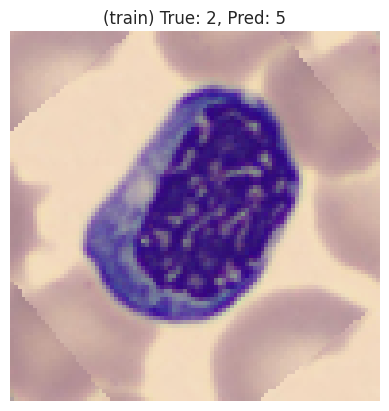

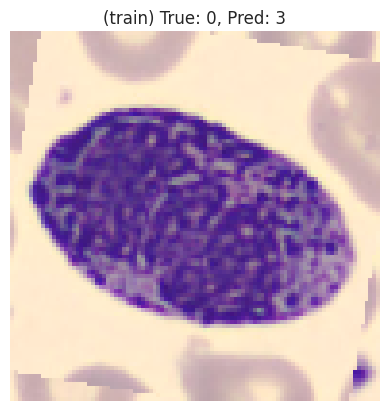

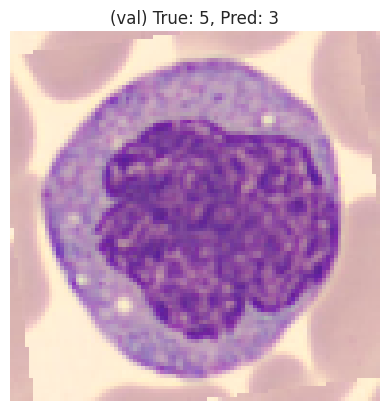

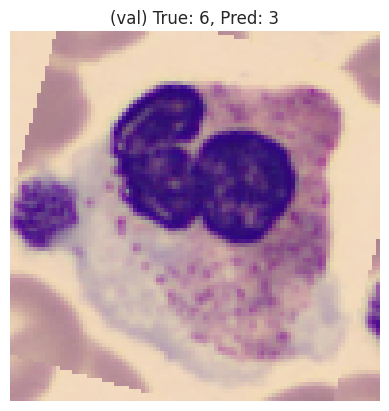

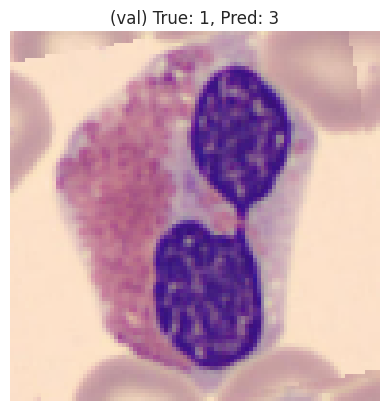

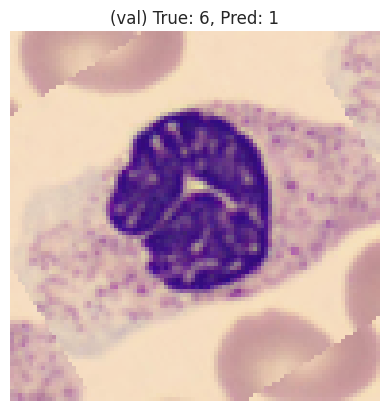

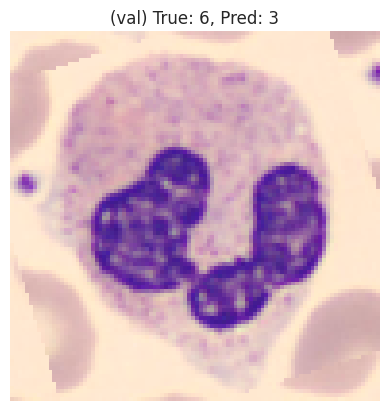

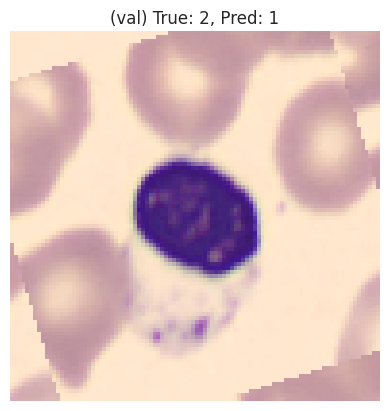

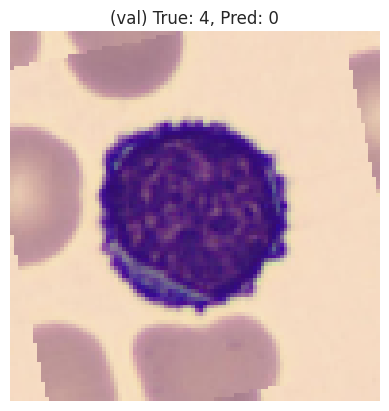

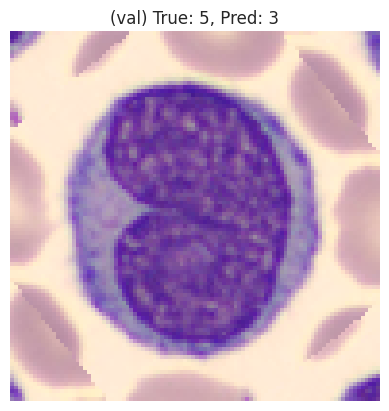

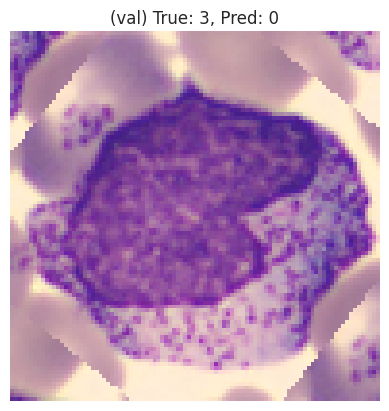

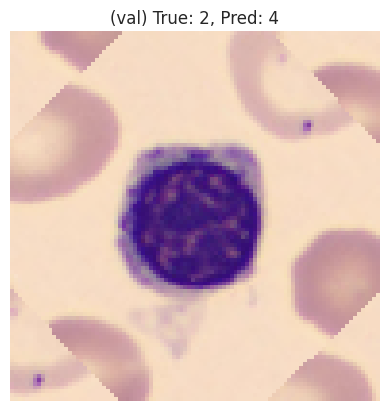

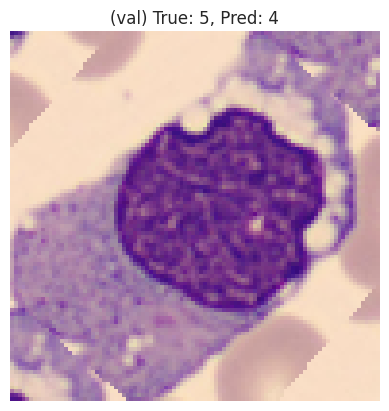

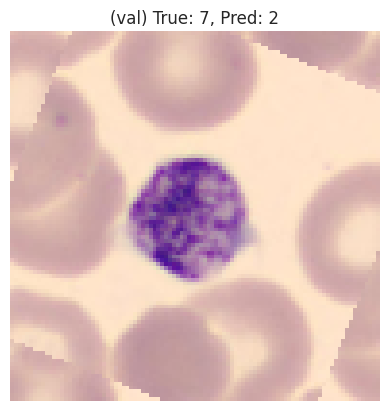

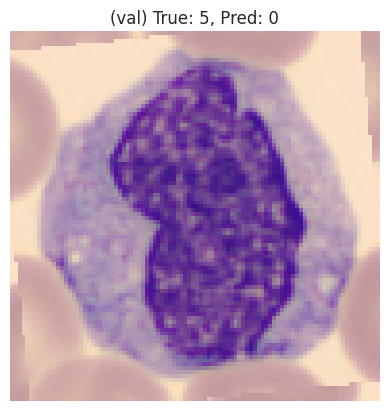

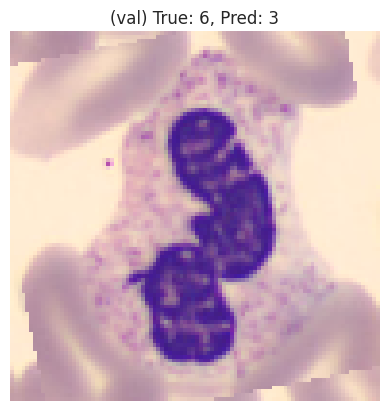

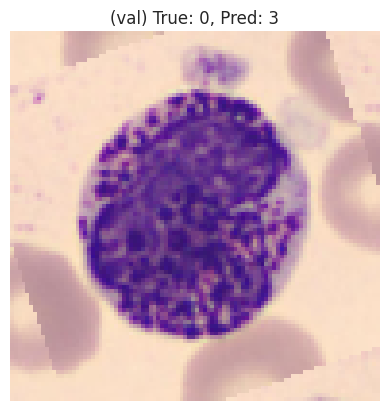

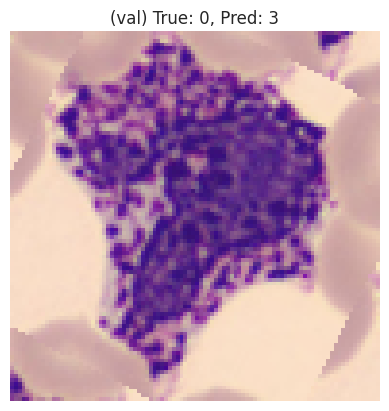

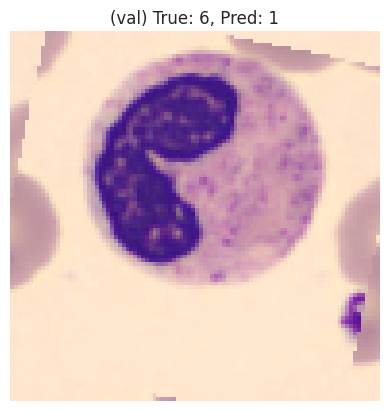

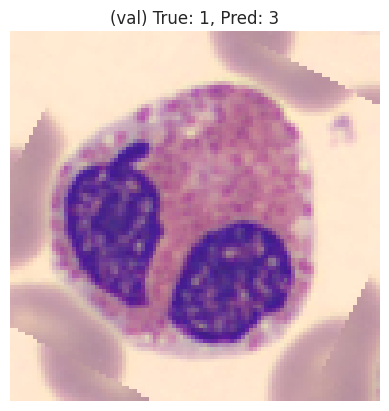

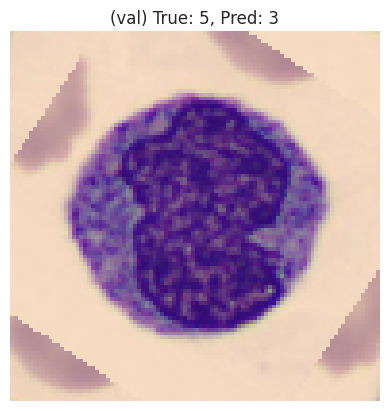

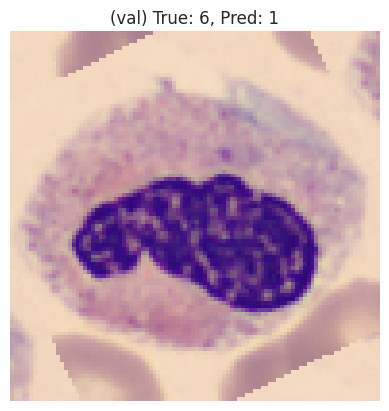

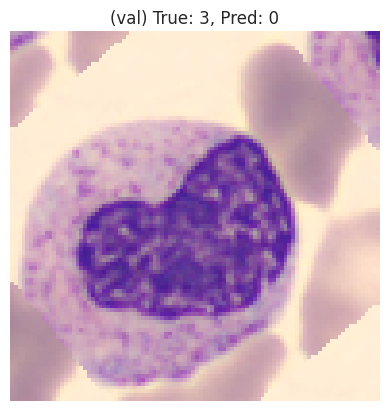

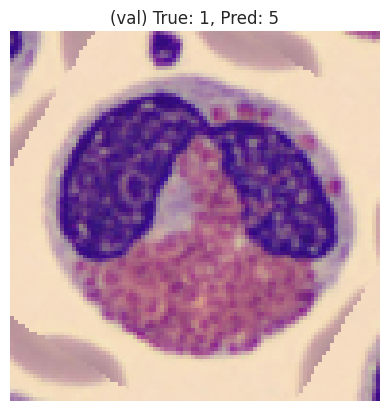

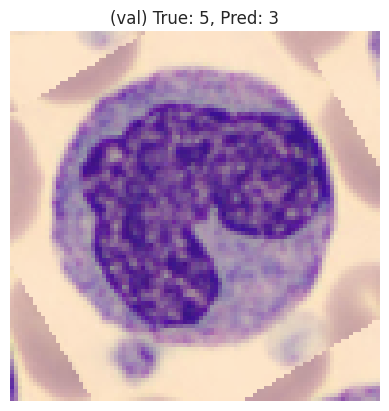

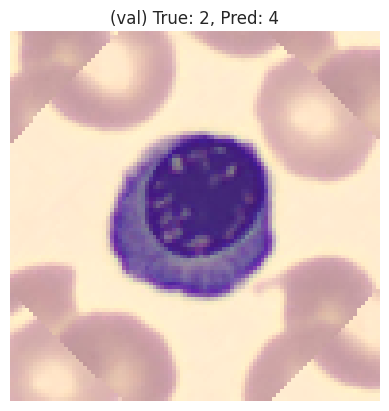

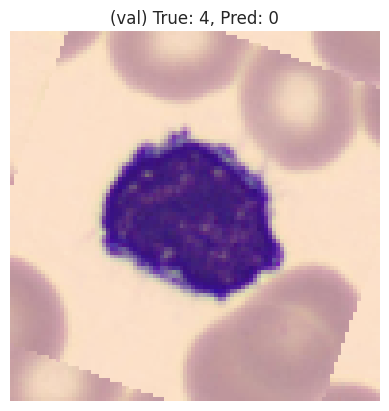

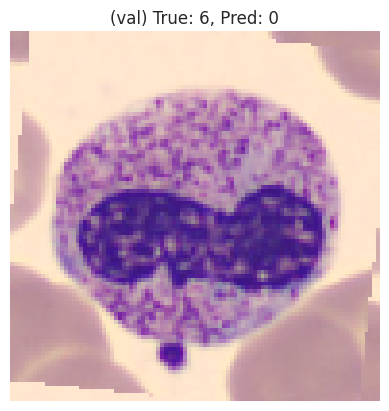

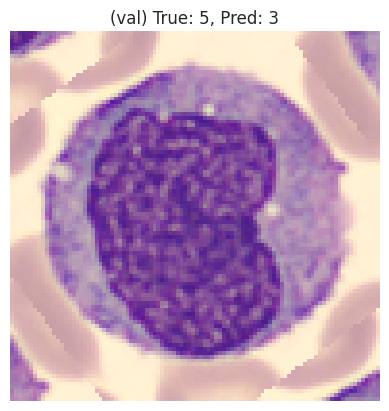

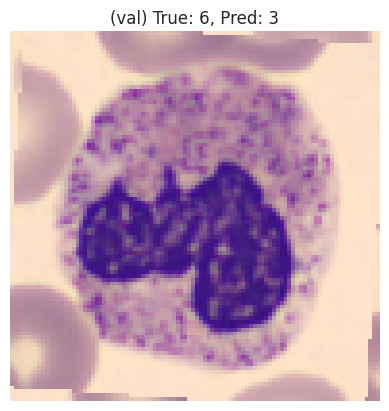

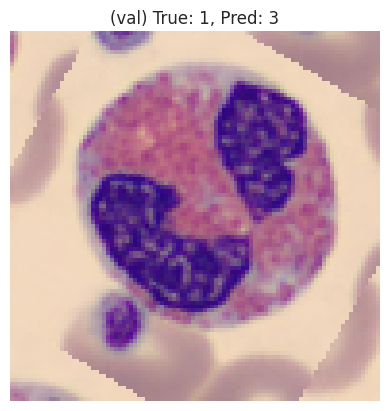

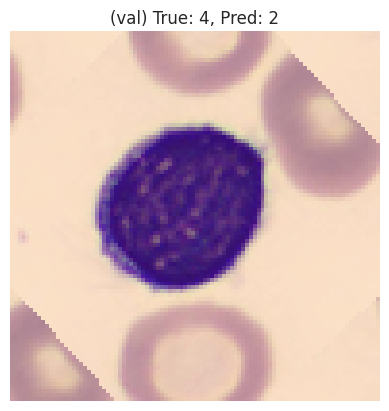

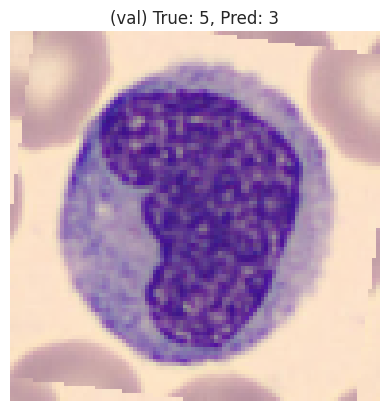

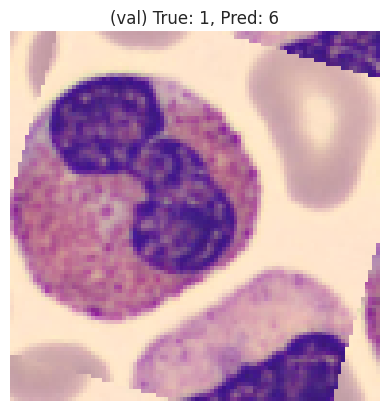

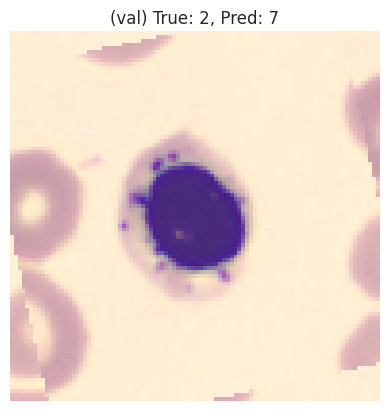

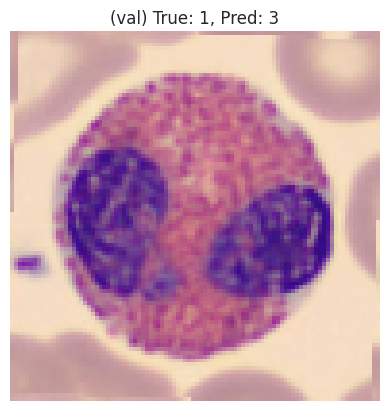

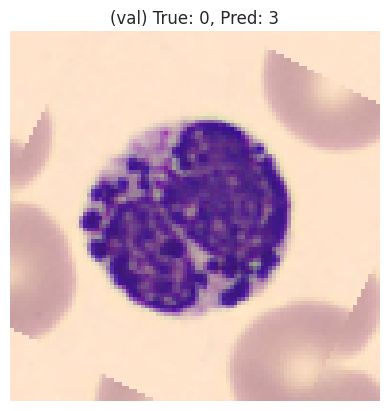

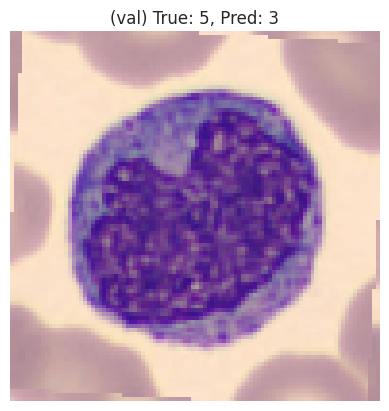

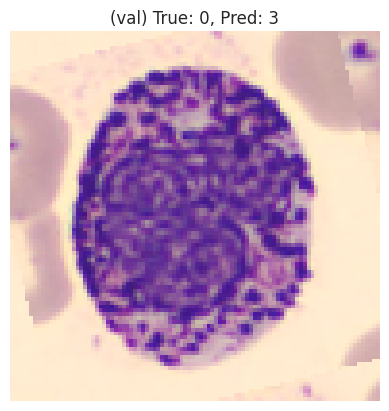

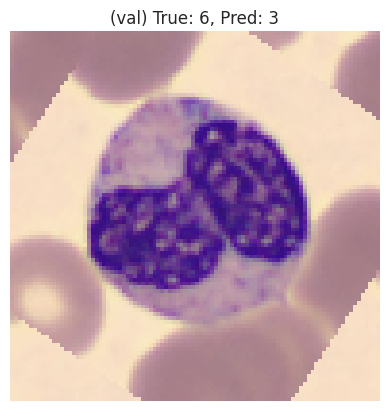

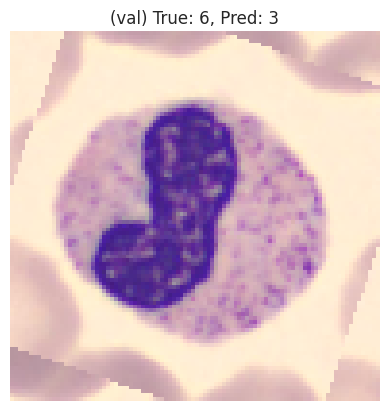

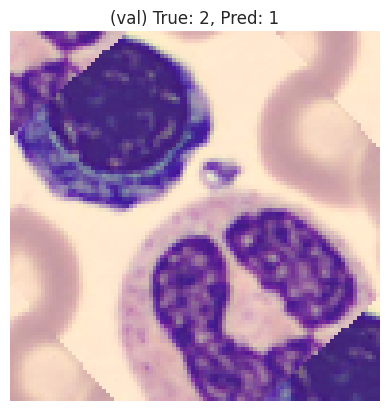

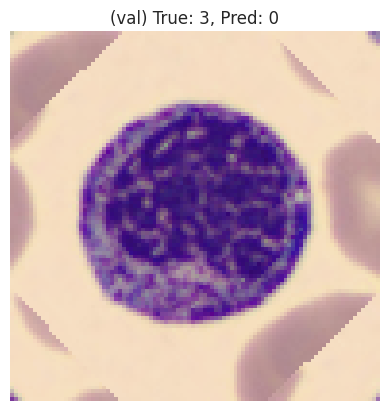

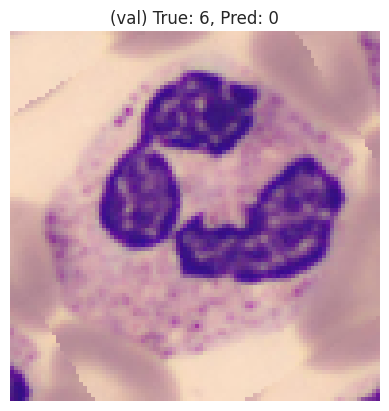

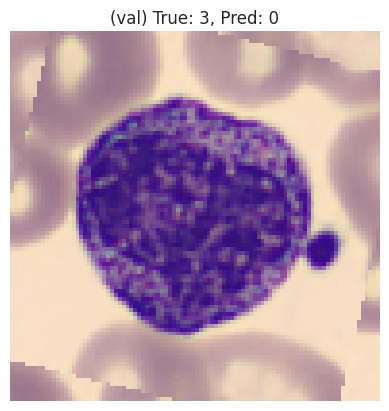

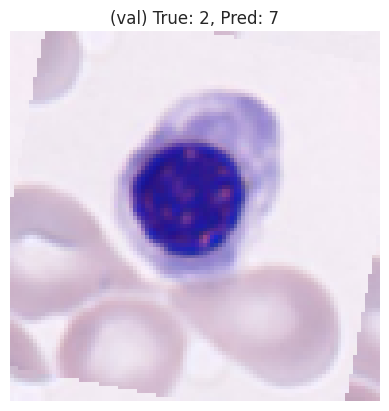

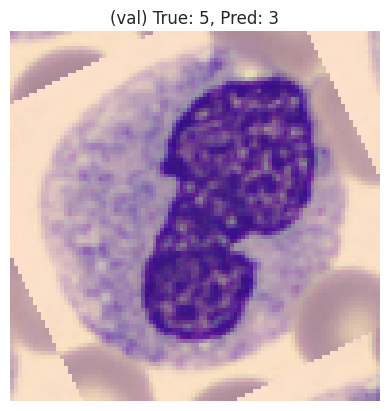

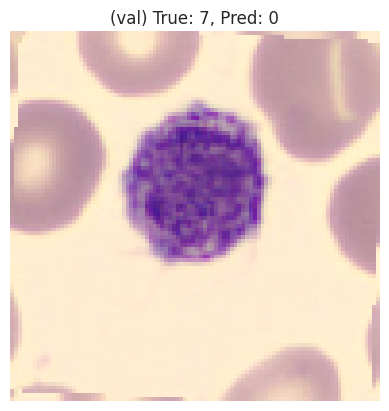

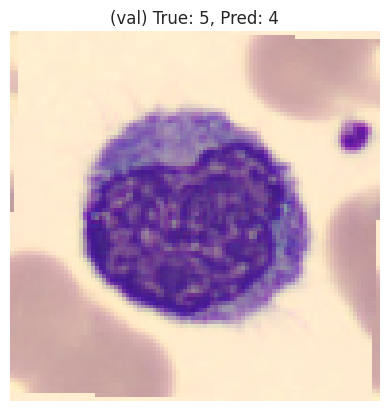

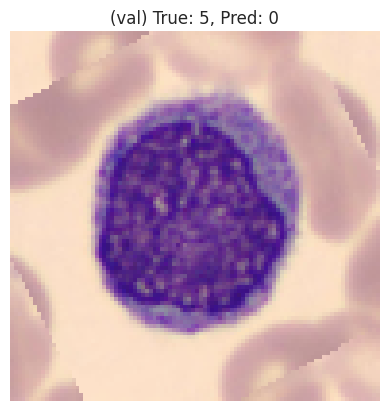

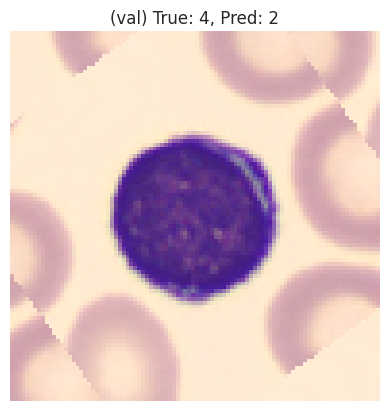

In [26]:
for set_, (y_true, y_pred) in outputs.items():
    set_images = 50
    images = X_train if set_ == "train" else X_val
    for image, instance_true, instance_pred in zip(images, y_true, y_pred):
        if instance_true == instance_pred:
            continue
        set_images -= 1
        if set_images == 0:
            break
        plt.imshow(image / 255)
        plt.axis("off")
        plt.title(f"({set_}) True: {instance_true}, Pred: {instance_pred}")
        plt.show()

In [27]:
def plot_image_grid(images, y_true, y_pred, indices, n_cols=3):
    n_rows = -(-len(indices) // n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    for ax, i in zip(axes.flatten(), indices):
        ax.imshow(images[i])
        ax.set_title(f"True: {y_true[i]}, Pred: {y_pred[i]}")
        ax.axis("off")
    return fig